<a href="https://www.kaggle.com/code/mikedelong/treemaps-for-trees?scriptVersionId=139740928" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
from glob import glob
from pandas import concat
from pandas import read_csv

df = concat([read_csv(filepath_or_buffer=input_file, parse_dates=['most_recent_observation', 'planted_date', 'retired_date'],
                      low_memory=False,) for input_file in glob('/kaggle/input/5m-trees-dataset/*Final*.csv')])
df[['genus', 'species']] = df['scientific_name'].str.split(expand=True, n=1)
# expect (5660237, 30)
print(df.shape)

(5660237, 30)


In [2]:
df.columns

Index(['most_recent_observation', 'most_recent_observation_type',
       'common_name', 'scientific_name', 'city', 'state',
       'longitude_coordinate', 'latitude_coordinate', 'location_name',
       'diameter_breast_height_CM', 'height_M', 'native', 'height_binned_M',
       'diameter_breast_height_binned_CM', 'greater_metro', 'city_ID',
       'tree_ID', 'planted_date', 'retired_date', 'location_type', 'zipcode',
       'address', 'neighborhood', 'ward', 'district', 'overhead_utility',
       'condition', 'percent_population', 'genus', 'species'],
      dtype='object')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5660237 entries, 0 to 17521
Data columns (total 30 columns):
 #   Column                            Dtype         
---  ------                            -----         
 0   most_recent_observation           object        
 1   most_recent_observation_type      object        
 2   common_name                       object        
 3   scientific_name                   object        
 4   city                              object        
 5   state                             object        
 6   longitude_coordinate              float64       
 7   latitude_coordinate               float64       
 8   location_name                     object        
 9   diameter_breast_height_CM         float64       
 10  height_M                          float64       
 11  native                            object        
 12  height_binned_M                   object        
 13  diameter_breast_height_binned_CM  object        
 14  greater_metro       

<Axes: >

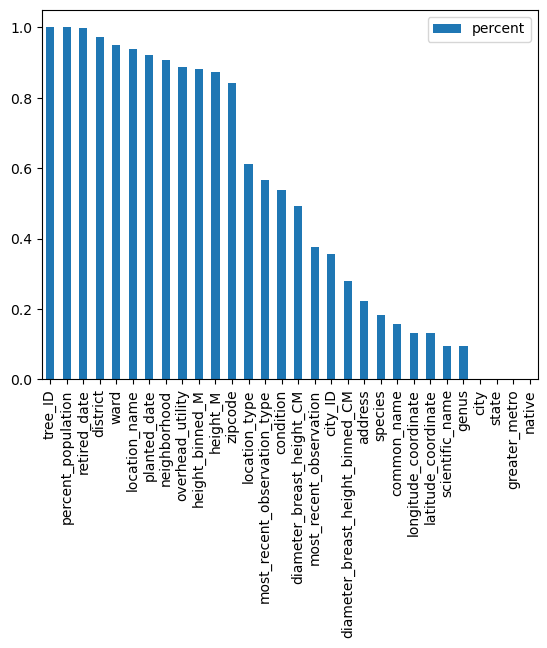

In [4]:
# info() doesn't return our isna counts, so we need to get them
isna_df = df.isna().sum().to_frame()
isna_df['percent'] = isna_df[0]/len(df)
isna_df.sort_values(ascending=False, by='percent')[['percent']].plot(kind='bar')

We really need an interactive widget to be able to understand much about this data. Let's try to look at the state and city data first.

In [5]:
from plotly.express import treemap
state_city = ['state', 'city']
treemap(data_frame=df.groupby(by=state_city).size().reset_index(), path=state_city, values=0).show()

We can similarly combine the state with the scientific name data; trying to cmbine it with the city data (too) might be a bit much. 

In [6]:
from plotly.express import treemap
state_species = ['state', 'genus', 'species']
treemap(data_frame=df.groupby(by=state_species).size().reset_index(), path=state_species, values=0).show()

In [7]:
# how many states do we have data for?
df['state'].nunique()

33

In [8]:
from plotly.express import choropleth
state_genus = ['state', 'genus']
state_genus_df = df[state_genus].groupby(state_genus).size().sort_values(ascending=False).reset_index().drop_duplicates(subset='state')
# we need to add in state abbreviations to get the choropleth to work
state_abbrev_df = state_abbrev_df = read_csv(filepath_or_buffer='/kaggle/input/state-abbreviations/state_abbrev.csv', usecols=['State', 'Abbreviation'])
state_genus_df = state_genus_df.merge(right=state_abbrev_df, right_on='State', left_on='state').drop(columns=['State'])
choropleth(locationmode='USA-states', scope='usa', data_frame=state_genus_df, locations = 'Abbreviation',  color='genus',
          title='Most popular genus of tree in each state').show()

In [9]:
from plotly.express import colors
state_common_name = ['state', 'common_name']
vacant_common = {item for item in df['common_name'].unique() if isinstance(item, str) and 'vacant' in item.lower()}
state_common_name_df = df[~df['common_name'].isin(vacant_common)][state_common_name].groupby(state_common_name).size().sort_values(ascending=False).reset_index().drop_duplicates(subset='state').merge(right=state_abbrev_df, right_on='State', left_on='state').drop(columns=['State'])
choropleth(locationmode='USA-states', scope='usa', data_frame=state_common_name_df, locations = 'Abbreviation', color='common_name', 
           color_discrete_sequence=colors.qualitative.Light24, title='Most popular tree in each state').show()

In [10]:
df['native'].value_counts()

introduced             2982241
naturally_occurring    1398442
no_info                1279554
Name: native, dtype: int64

Let's map the percentage that are known to be native among the trees that we know are either native or introduced.

In [11]:
t0_df = df[df['native'] != 'no_info'].groupby(['state', 'native'])['native'].count().to_frame().rename(columns={'native': 'count'}).reset_index()
native_df = t0_df[t0_df['native'] == 'naturally_occurring'].drop(columns=['native']).rename(columns={'count': 'native'}).merge(right=t0_df.drop(columns=['native']).groupby(['state']).sum().reset_index().rename(columns={'count': 'total'}), on='state')
native_df['native (%)'] = 100 * native_df['native'] / native_df['total']
native_df = native_df.merge(right=state_abbrev_df, right_on='State', left_on='state').drop(columns=['State'])
choropleth(locationmode='USA-states', scope='usa', data_frame=native_df, locations = 'Abbreviation', color='native (%)', title='Fraction of trees that are native').show()
# and clean up our temporary
del t0_df